# Interactive labeling example with gridsearch

In [1]:
# Import all necessary libraries
import numpy as np

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

import pickle as pkl

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

## Dataset
For our classifier, we load the digits dataset from scikit-learn.

In [2]:
n_initial = 100

X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)

X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)

## Selecting the best classifier

We will use a grid search to find the best classifier for our dataset.

In [3]:
# Decision tree
grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [i for i in range(1, 11)],
    'min_samples_split': [i for i in range(2, 11)],
    'min_samples_leaf': [i for i in range(1, 11)]
}

gridsearch_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), grid_dt, cv=5, n_jobs=-1)
gridsearch_dt.fit(X_initial, y_initial)

print("Best params for Decision Tree: ", gridsearch_dt.best_params_)
print("Score", gridsearch_dt.best_score_)

c:\Users\ana12\anaconda3\envs\TFM-SSAL\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best params for Decision Tree:  {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4}
Score 0.62


In [4]:
# Random forest
grid_rf = {
    'n_estimators': [i for i in range(1, 101, 25)],
    'criterion': ['gini', 'entropy'],
    'max_depth': [i for i in range(1, 11, 3)],
    'min_samples_split': [i for i in range(2, 11, 3)],
    'min_samples_leaf': [i for i in range(1, 11, 3)]
}

gridsearch_rf = GridSearchCV(RandomForestClassifier(random_state=42), grid_rf, cv=5, n_jobs=-1)
gridsearch_rf.fit(X_initial, y_initial)



print("Best params for Random Forest: ", gridsearch_rf.best_params_)
print("Score", gridsearch_rf.best_score_)

c:\Users\ana12\anaconda3\envs\TFM-SSAL\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best params for Random Forest:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 51}
Score 0.9199999999999999


c:\Users\ana12\anaconda3\envs\TFM-SSAL\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Random Forest with params  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 51} shows better performance than the other classifiers. To implement the active learner with this parameters, we can store the model in a `.pkl` file and load it in the active learner. Another option is to directly use the variable that stores the model and pass it to the active learner or manually write the parameters in the active learner.

In [5]:
pkl.dump(gridsearch_rf.best_estimator_, open("randomForest.pkl", "wb"))

## Initializing the learner
We initialize the active learner with the uncertainty sampling strategy and the classifier.

In [8]:
rf_model = pkl.load(open("randomForest.pkl", "rb"))

In [9]:
learner = ActiveLearner(
    estimator=rf_model,
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)

We set the number of queries we want to make to 20.

In [7]:
n_queries = 10

## The active learning loop

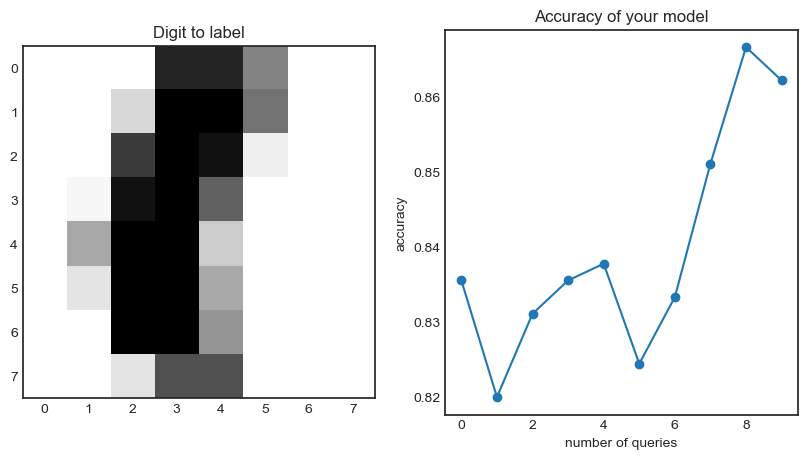

Which digit is this?


In [11]:
# Initialize accuracy storage
accuracy_scores = [learner.score(X_test, y_test)]

for i in range(n_queries):
    display.clear_output(wait=True)
    # query for labels
    query_idx, query_inst = learner.query(X_pool)
    with plt.style.context('seaborn-v0_8-white'):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Digit to label')
        plt.imshow(query_inst.reshape(8, 8))
        plt.subplot(1, 2, 2)
        plt.title('Accuracy of your model')
        plt.plot(range(i+1), accuracy_scores)
        plt.scatter(range(i+1), accuracy_scores)
        plt.xlabel('number of queries')
        plt.ylabel('accuracy')
        display.display(plt.gcf())
        plt.close('all')

    print("Which digit is this?")
    y_new = np.array([int(input())], dtype=int)
    # add new label to train set and retrain
    learner.teach(query_inst.reshape(1, -1), y_new)
    # pool update
    X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    # update the accuracy scores
    accuracy_scores.append(learner.score(X_test, y_test))

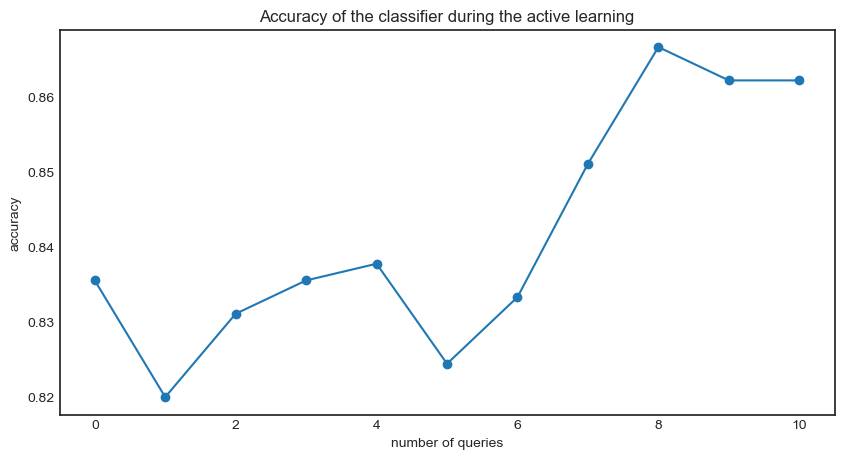

In [12]:
with plt.style.context('seaborn-v0_8-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of the classifier during the active learning')
    plt.plot(range(n_queries+1), accuracy_scores)
    plt.scatter(range(n_queries+1), accuracy_scores)
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.show()

## What if we train the same model with random samples?

In [10]:
# Add n random samples to the training set
n_additional = n_queries
additional_idx = np.random.choice(range(len(X_pool)), size=n_additional, replace=False)

X_additional, y_additional = X_pool[additional_idx], y_pool[additional_idx]

X_rf = np.vstack((X_initial, X_additional))
y_rf = np.hstack((y_initial, y_additional))

clf = RandomForestClassifier(
    criterion='entropy',
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=51,
    random_state=42  
)

clf.fit(X_rf, y_rf)

clf.score(X_test, y_test)

0.84